## Two Way Method

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math
from utility_func import *
import scipy.io as sio
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import gmtime, strftime
import random
import os

# Device will determine whether to run the training on GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Setting Simulation and Hyperparameters
Setting up the hyperparameters for the training purpose.

$N$: Number of Transmitters. \
$M$: Number of Receivers. \
$L$: Total length of pilot transmission. 

In [31]:
# Define communication parameters 
N = 64                              # Number of transmit antenna
M = 1                               # Number of receive antenna
L = 20                              # Number of ping pong rounds
SNR_dB = torch.tensor(0)            # Signal to Noise Ratio in dB
P_dBm = torch.tensor(0)             # Transmitter and Receiver's power
SNR = 10**(SNR_dB/10)               # Signal to Noise Ratio in linear scale
P = 10**(P_dBm/10)                  # Transmit power in linear scale
N0 = P/SNR                          # Noise power in linear scale

# Define hyperparameters
batch_size = 1024
n_epochs = 20
max_epochs = 50

# Define parameters for NN 
input_sizeTx, input_sizeRx = 2*N*L, 2*L
output_sizeTx, output_sizeRx = 3*N, M                     # Output size of sensing output of A 
sim_parameters = (N, M, L, N0)

### Preparing Sensing Data for Pilot Transmission
Note that it is crucial to use the same sensing data during pilot stage so that the neural network is able to learn the channel distribution.

In [32]:
"""Make sensing polarization vectors and beamformer"""
# Polarization vectors used in pilot stage
Pol_BS_t, Pol_BS_r, Pol_UE_t, Pol_UE_r, Pol_BS_t_blk, Pol_BS_r_blk_T, Pol_UE_t_blk, Pol_UE_r_blk_T \
    = MISO_polarization_pilot_tensor_fixed(N, M, L)

# Transmit beamformer used in the pilot stage
W_A_t_real = torch.randn((L, 1, N))
W_A_t_imag = torch.randn((L, 1, N))
W_A_t = torch.complex(W_A_t_real, W_A_t_imag)
W_A_t = W_A_t / torch.norm(W_A_t, dim=2, keepdim=True)
W_A_t = torch.transpose(W_A_t, 1, 2) * torch.sqrt(P)

### Preparing Training Data

In [33]:
"""Generate H_p channel batch data"""
# total number of generated samples
num_generated_sample = batch_size * 100 
# H_p generation
H_p_training_shaped = channel_generation_batch_tensor(num_generated_sample, N, M)
y_real_tx_train, y_real_rx_train = generate_twoway_pilots(H_p_training_shaped, Pol_BS_t_blk, 
                                                          Pol_BS_r_blk_T, Pol_UE_t_blk, Pol_UE_r_blk_T, 
                                                          W_A_t, sim_parameters)

### Preparing Test Data

In [34]:
"""Generate H_p channel batch data"""
# total number of generated samples
num_generated_testing_sample = 1000
# H_p generation
H_p_testing_batch = channel_generation_batch_tensor(num_generated_testing_sample, N, M)
y_real_tx_test, y_real_rx_test = generate_twoway_pilots(H_p_testing_batch, Pol_BS_t_blk,
                                                        Pol_BS_r_blk_T, Pol_UE_t_blk, Pol_UE_r_blk_T,
                                                        W_A_t, sim_parameters)

### Two Way Protocol

In [35]:
def TwoWay(H, MLP_tx, MLP_rx, y_real_tx, y_real_rx):
    'Calculate final optimal outputs'
    # Transmitter side 
    output_A_t = MLP_tx(y_real_tx)
    angle_A_t = torch.sigmoid(output_A_t[:,:N]) * torch.pi
    angle_A_t = angle_A_t.unsqueeze(1)
    Pol_A_t = torch.hstack((torch.cos(angle_A_t), torch.sin(angle_A_t)))
    Pol_A_t_blk = vec2block_diag(Pol_A_t).to(torch.complex64)

    W_A_t = output_A_t[:,N:]
    W_A_t_norm = torch.norm(W_A_t, dim=1,keepdim=True)
    W_A_t = W_A_t/W_A_t_norm
    W_A_t = torch.complex(W_A_t[:,:N], W_A_t[:,N:])
    W_A_t = W_A_t.unsqueeze(-1)
    
    # Receiver side
    output_B_r = MLP_rx(y_real_rx)
    angle_B_r = torch.sigmoid(output_B_r) * torch.pi
    Pol_B_r = torch.hstack((torch.cos(angle_B_r), torch.sin(angle_B_r)))
    Pol_B_r = Pol_B_r.unsqueeze(-1)
    Pol_B_r_blk = vec2block_diag(Pol_B_r)
    Pol_B_r_blk_T = torch.transpose(Pol_B_r_blk, 1, 2).to(torch.complex64)

    Heff_final = Pol_B_r_blk_T @ H @ Pol_A_t_blk
    y_final = Heff_final @ W_A_t
    
    return y_final

### MLP Model Class 
It is easy to define the Fully Connected Neural Network in this way becuase dimension can arbitrarly change. 

In [36]:
class MLPBlock(nn.Module):
    def __init__(self, num_layers, dims):
        super(MLPBlock, self).__init__()

        layers = []
        for i in range(num_layers - 2):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(dims[i + 1]))

        layers.append(nn.Linear(dims[-2], dims[-1]))
        self.mlp = nn.Sequential(*layers)

    def forward(self, inputs):
        return self.mlp(inputs)

### Beamforming Model Class

In [37]:
class BeamformingModel(nn.Module):
    def __init__(self, MLP_tx_dim, MLP_rx_dim):
        super(BeamformingModel, self).__init__()
        self.MLP_tx = MLPBlock(len(MLP_tx_dim), MLP_tx_dim)
        self.MLP_rx = MLPBlock(len(MLP_rx_dim), MLP_rx_dim)

    def forward(self, H, y_tx, y_rx):
        bf_loss = TwoWay(H, self.MLP_tx, self.MLP_rx, y_tx, y_rx)
        
        return bf_loss

### Beamforming Loss

In [38]:
def beamforming_loss(bf):
    bf_gain = torch.mean(torch.abs(bf)**2)
    return -bf_gain

### Training

/Users/seungcheoloh/Desktop/Primary/Research/DNN Applied P_MIMO/Two_Way_MISO_Method/trained_TwoWay_model/02-20_19_50_36


  2%|▏         | 1/50 [00:43<35:13, 43.13s/it]

epoch 0   loss_train:3.90890   loss_test:4.04345   best_test:-inf   no_increase: 0 lr: [0.0009833337214848017]


  4%|▍         | 2/50 [01:24<33:41, 42.12s/it]

epoch 1   loss_train:4.98498   loss_test:4.97570   best_test:4.04345   no_increase: 0 lr: [0.0009677193833158022]


  6%|▌         | 3/50 [02:05<32:34, 41.59s/it]

epoch 2   loss_train:5.34476   loss_test:5.34950   best_test:4.97570   no_increase: 0 lr: [0.0009523529849368548]


  8%|▊         | 4/50 [02:46<31:41, 41.33s/it]

epoch 3   loss_train:5.53641   loss_test:5.53438   best_test:5.34950   no_increase: 0 lr: [0.0009372305893165697]


 10%|█         | 5/50 [03:28<31:04, 41.44s/it]

epoch 4   loss_train:5.65990   loss_test:5.65294   best_test:5.53438   no_increase: 0 lr: [0.0009223483219396084]


 12%|█▏        | 6/50 [04:10<30:35, 41.71s/it]

epoch 5   loss_train:5.74239   loss_test:5.73551   best_test:5.65294   no_increase: 0 lr: [0.0009077023698139884]


 14%|█▍        | 7/50 [04:54<30:30, 42.57s/it]

epoch 6   loss_train:5.78997   loss_test:5.78941   best_test:5.73551   no_increase: 0 lr: [0.0008932889804941583]


 16%|█▌        | 8/50 [05:36<29:41, 42.42s/it]

epoch 7   loss_train:5.81404   loss_test:5.81481   best_test:5.78941   no_increase: 0 lr: [0.0008791044611195806]


 18%|█▊        | 9/50 [06:21<29:25, 43.07s/it]

epoch 8   loss_train:5.82505   loss_test:5.82974   best_test:5.81481   no_increase: 0 lr: [0.0008651451774685831]


 20%|██        | 10/50 [07:04<28:49, 43.24s/it]

epoch 9   loss_train:5.83920   loss_test:5.84212   best_test:5.82974   no_increase: 0 lr: [0.0008514075530272329]


 22%|██▏       | 11/50 [07:46<27:50, 42.84s/it]

epoch 10   loss_train:5.84873   loss_test:5.85605   best_test:5.84212   no_increase: 0 lr: [0.000837888068072996]


 24%|██▍       | 12/50 [08:30<27:13, 42.98s/it]

epoch 11   loss_train:5.88051   loss_test:5.87533   best_test:5.85605   no_increase: 0 lr: [0.0008245832587729483]


 26%|██▌       | 13/50 [09:14<26:41, 43.29s/it]

epoch 12   loss_train:5.89452   loss_test:5.89357   best_test:5.87533   no_increase: 0 lr: [0.0008114897162963057]


 28%|██▊       | 14/50 [09:57<25:54, 43.19s/it]

epoch 13   loss_train:5.91689   loss_test:5.91133   best_test:5.89357   no_increase: 0 lr: [0.000798604085941045]


 30%|███       | 15/50 [10:40<25:10, 43.17s/it]

epoch 14   loss_train:5.92878   loss_test:5.92905   best_test:5.91133   no_increase: 0 lr: [0.0007859230662743959]


 32%|███▏      | 16/50 [11:23<24:29, 43.23s/it]

epoch 15   loss_train:5.94154   loss_test:5.94496   best_test:5.92905   no_increase: 0 lr: [0.0007734434082869778]


 34%|███▍      | 17/50 [12:07<23:48, 43.30s/it]

epoch 16   loss_train:5.95168   loss_test:5.95798   best_test:5.94496   no_increase: 0 lr: [0.0007611619145603713]


 36%|███▌      | 18/50 [12:49<23:01, 43.19s/it]

epoch 17   loss_train:5.97600   loss_test:5.96844   best_test:5.95798   no_increase: 0 lr: [0.0007490754384479052]


 38%|███▊      | 19/50 [13:33<22:19, 43.20s/it]

epoch 18   loss_train:5.96165   loss_test:5.97476   best_test:5.96844   no_increase: 0 lr: [0.0007371808832684528]


 40%|████      | 20/50 [14:16<21:34, 43.16s/it]

epoch 19   loss_train:5.97823   loss_test:5.97890   best_test:5.97476   no_increase: 0 lr: [0.0007254752015130315]


 42%|████▏     | 21/50 [14:58<20:45, 42.94s/it]

epoch 20   loss_train:6.00006   loss_test:5.98208   best_test:5.97890   no_increase: 0 lr: [0.0007139553940639969]


 44%|████▍     | 22/50 [15:41<19:57, 42.78s/it]

epoch 21   loss_train:5.98485   loss_test:5.98444   best_test:5.98208   no_increase: 0 lr: [0.0007026185094266397]


 46%|████▌     | 23/50 [16:23<19:12, 42.70s/it]

epoch 22   loss_train:5.98599   loss_test:5.98635   best_test:5.98444   no_increase: 0 lr: [0.0006914616429729803]


 48%|████▊     | 24/50 [17:05<18:27, 42.60s/it]

epoch 23   loss_train:5.98270   loss_test:5.98791   best_test:5.98635   no_increase: 0 lr: [0.0006804819361975742]


 50%|█████     | 25/50 [17:48<17:44, 42.58s/it]

epoch 24   loss_train:5.98932   loss_test:5.99004   best_test:5.98791   no_increase: 0 lr: [0.0006696765759851322]


 52%|█████▏    | 26/50 [18:30<17:00, 42.53s/it]

epoch 25   loss_train:5.99253   loss_test:5.99129   best_test:5.99004   no_increase: 0 lr: [0.0006590427938897716]


 54%|█████▍    | 27/50 [19:13<16:17, 42.50s/it]

epoch 26   loss_train:5.99781   loss_test:5.99224   best_test:5.99129   no_increase: 0 lr: [0.0006485778654257108]


 56%|█████▌    | 28/50 [19:55<15:33, 42.45s/it]

epoch 27   loss_train:5.99778   loss_test:5.99279   best_test:5.99224   no_increase: 0 lr: [0.0006382791093692286]


 58%|█████▊    | 29/50 [20:38<14:51, 42.47s/it]

epoch 28   loss_train:5.99288   loss_test:5.99308   best_test:5.99279   no_increase: 0 lr: [0.0006281438870717055]


 60%|██████    | 30/50 [21:20<14:08, 42.43s/it]

epoch 29   loss_train:5.99787   loss_test:5.99394   best_test:5.99308   no_increase: 0 lr: [0.000618169601783576]


 62%|██████▏   | 31/50 [22:02<13:26, 42.43s/it]

epoch 30   loss_train:5.98738   loss_test:5.99512   best_test:5.99394   no_increase: 0 lr: [0.0006083536979890128]


 64%|██████▍   | 32/50 [22:45<12:44, 42.45s/it]

epoch 31   loss_train:6.00218   loss_test:5.99596   best_test:5.99512   no_increase: 0 lr: [0.0005986936607511782]


 66%|██████▌   | 33/50 [23:28<12:02, 42.52s/it]

epoch 32   loss_train:6.00221   loss_test:5.99664   best_test:5.99596   no_increase: 0 lr: [0.0005891870150678697]


 68%|██████▊   | 34/50 [24:10<11:21, 42.57s/it]

epoch 33   loss_train:5.99528   loss_test:5.99765   best_test:5.99664   no_increase: 0 lr: [0.0005798313252374002]


 70%|███████   | 35/50 [24:53<10:38, 42.57s/it]

epoch 34   loss_train:6.00087   loss_test:5.99810   best_test:5.99765   no_increase: 0 lr: [0.000570624194234545]


 72%|███████▏  | 36/50 [25:36<09:58, 42.77s/it]

epoch 35   loss_train:6.01213   loss_test:5.99877   best_test:5.99810   no_increase: 0 lr: [0.0005615632630963988]


 74%|███████▍  | 37/50 [26:20<09:19, 43.00s/it]

epoch 36   loss_train:6.00705   loss_test:5.99858   best_test:5.99877   no_increase: 0 lr: [0.0005526462103179852]


 76%|███████▌  | 38/50 [27:03<08:36, 43.08s/it]

epoch 37   loss_train:6.00378   loss_test:5.99940   best_test:5.99877   no_increase: 1 lr: [0.0005438707512574627]


 78%|███████▊  | 39/50 [27:45<07:52, 42.93s/it]

epoch 38   loss_train:5.99899   loss_test:6.00037   best_test:5.99940   no_increase: 0 lr: [0.0005352346375507765]


 80%|████████  | 40/50 [28:28<07:08, 42.82s/it]

epoch 39   loss_train:6.00287   loss_test:6.00082   best_test:6.00037   no_increase: 0 lr: [0.0005267356565356023]


 82%|████████▏ | 41/50 [29:10<06:24, 42.70s/it]

epoch 40   loss_train:5.99504   loss_test:6.00038   best_test:6.00082   no_increase: 0 lr: [0.0005183716306844416]


 84%|████████▍ | 42/50 [29:53<05:42, 42.78s/it]

epoch 41   loss_train:5.99990   loss_test:6.00093   best_test:6.00082   no_increase: 1 lr: [0.0005101404170467145]


 86%|████████▌ | 43/50 [30:36<04:58, 42.69s/it]

epoch 42   loss_train:5.99902   loss_test:6.00139   best_test:6.00093   no_increase: 0 lr: [0.0005020399066997145]


 88%|████████▊ | 44/50 [31:18<04:15, 42.59s/it]

epoch 43   loss_train:6.00113   loss_test:6.00154   best_test:6.00139   no_increase: 0 lr: [0.0004940680242082795]


 90%|█████████ | 45/50 [32:01<03:33, 42.63s/it]

epoch 44   loss_train:6.00747   loss_test:6.00230   best_test:6.00154   no_increase: 0 lr: [0.00048622272709304524]


 92%|█████████▏| 46/50 [32:44<02:50, 42.66s/it]

epoch 45   loss_train:6.00343   loss_test:6.00249   best_test:6.00230   no_increase: 0 lr: [0.00047850200530713907]


 94%|█████████▍| 47/50 [33:26<02:07, 42.58s/it]

epoch 46   loss_train:6.00424   loss_test:6.00274   best_test:6.00249   no_increase: 0 lr: [0.00047090388072118625]


 96%|█████████▌| 48/50 [34:09<01:25, 42.75s/it]

epoch 47   loss_train:6.00994   loss_test:6.00381   best_test:6.00274   no_increase: 0 lr: [0.00046342640661649256]


 98%|█████████▊| 49/50 [34:54<00:43, 43.22s/it]

epoch 48   loss_train:6.00198   loss_test:6.00375   best_test:6.00381   no_increase: 0 lr: [0.00045606766718627356]


100%|██████████| 50/50 [35:38<00:00, 42.77s/it]

epoch 49   loss_train:6.00895   loss_test:6.00401   best_test:6.00381   no_increase: 1 lr: [0.00044882577704480624]


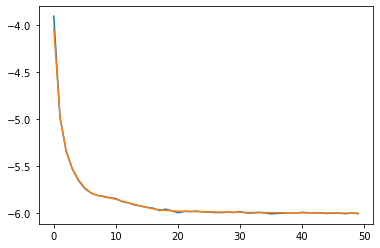

In [39]:
"""Get parameters for the model"""
MLP_tx_dim = [input_sizeTx, 256, 256, output_sizeTx]
MLP_rx_dim = [input_sizeRx, 128, 128, output_sizeRx]

'Calling the model'
model = BeamformingModel(MLP_tx_dim, MLP_rx_dim)

exp_id = strftime("%m-%d_%H_%M_%S", gmtime())
output_dir = f'/Users/seungcheoloh/Desktop/Primary/Research/DNN Applied P_MIMO/Two_Way_MISO_Method/trained_TwoWay_model/{exp_id}'

os.makedirs(output_dir, exist_ok=True)
print(output_dir)

# Setting learning rate and optimizers
learning_rate = 0.001
optimizer_bf = optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer_bf, gamma=0.9992)

# Initializer
no_increase = 0 
best_loss = float('inf')

# Initizalize lists for data visualization
training_loss = []
test_loss = []
epochs = []

for epoch in tqdm(range(max_epochs)):
    batch_iter = 0
    
    for epoch_per_batch in range(n_epochs):
        model.train()
        rnd_indices = torch.randint(num_generated_sample, (batch_size,))
        H_p_batch = H_p_training_shaped[rnd_indices]
        y_tx_train = y_real_tx_train[rnd_indices]
        y_rx_train = y_real_rx_train[rnd_indices]

        # Zeros the gradients
        optimizer_bf.zero_grad()

        # Forward pass
        bf = model(H_p_batch, y_tx_train, y_rx_train)
        loss = beamforming_loss(bf)
        rate_training_loss = -torch.mean(torch.log2(1+SNR*torch.abs(bf)**2))

        # Backward propagation
        loss.backward()

        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Set max_norm to your desired threshold
        
        # Optimizer
        optimizer_bf.step()
        lr_scheduler.step()
        batch_iter += 1

    """Evaluating Model"""
    model.eval()
    test_bf = model(H_p_testing_batch, y_real_tx_test, y_real_rx_test)
    rate_test_loss = -torch.mean(torch.log2(1+SNR*torch.abs(test_bf)**2))

    epochs.append(epoch)
    test_loss.append(rate_test_loss.detach().numpy())
    training_loss.append(rate_training_loss.detach().numpy())
    print('epoch', epoch, '  loss_train:%2.5f' % -rate_training_loss, '  loss_test:%2.5f' % -rate_test_loss, '  best_test:%2.5f  ' % -best_loss, 'no_increase:', no_increase, f"lr: {lr_scheduler.get_lr()}")
    
    if rate_test_loss < best_loss:
        torch.save(model.state_dict(), os.path.join(output_dir, f"{epoch}.pth"))
        best_loss = rate_test_loss 
        no_increase = 0
    else: 
        no_increase = no_increase + 1

    if no_increase > 20:
        break

plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, test_loss, label='Test Loss')
plt.savefig(os.path.join(output_dir, f"training_loss.png"))
plt.savefig(os.path.join(output_dir, f"test_loss.png"))
plt.show()